In [1]:
from main import read_in_blicks, BOUNDARY, eval_auc
import scorers
import datasets
import informants
import learners
import torch
import pandas as pd
import numpy as np
from util import entropy, kl_bern
from BayesianGLM import BayesianLearner
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/amanirmk/anaconda3/envs/informants/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.style.use('ggplot')

In [3]:
feature_type = 'atr_harmony'
SEED=1

## Load dataset, scorers, and oracle


In [4]:
lexicon_path = f'data/hw/{feature_type}_lexicon.txt'
phoneme_feature_path = f'data/hw/{feature_type}_features.txt'
ngram_feature_path = f'data/hw/{feature_type}_feature_weights.txt'

print(f'Loading lexicon from:\t{lexicon_path}')
dataset = datasets.load_lexicon(lexicon_path, min_length=2, max_length=5)

# You'll probably want to change this line to create your own scorer
mf_scorer = scorers.MeanFieldScorer(dataset, 
                                    feature_type=feature_type, 
                                    phoneme_feature_file=phoneme_feature_path,
                                   )

hw_scorer = scorers.HWScorer(dataset, 
                                    feature_type=feature_type, 
                                    phoneme_feature_file=phoneme_feature_path,
                            )

# Load oracle
informant = informants.HWInformant(dataset, hw_scorer)

Loading lexicon from:	data/hw/atr_harmony_lexicon.txt
Loading lexicon with min_length=2, max_length=5...
Reading phoneme features from: data/hw/atr_harmony_features.txt
# features:  512
feature type:  atr_harmony
Reading phoneme features from: data/hw/atr_harmony_features.txt
Loading ngram features from: data/hw/atr_harmony_feature_weights.txt


## Set random seeds

In [5]:
import random
import numpy as np
import torch

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
dataset.random.seed(SEED)

In [6]:
linear_train_dataset = dataset.data

## Load eval dataset

In [7]:
# Read in eval dataset

def load_eval_dataset():

    # Change this path if you want to specify a different eval dataset
    # eval_dataset_path = f'{feature_type}_test_set.txt'

    # Hacky, but the atr_harmony test set is stored at test_set.csv; the eval dataset names need to be standardized
    eval_dataset_path = 'test_set.csv'
    print(f'Reading eval items from:\t{eval_dataset_path}')
    items = read_in_blicks(eval_dataset_path)


    # Get phonemes
    phonemes = [[BOUNDARY] + item + [BOUNDARY] for item in items]
    # Encode items
    encoded_items = [dataset.vocab.encode(phon) for phon in phonemes]
    # Get labels with HW oracle
    labels = [informant.judge(encod) for encod in encoded_items]
    # Featurize items
    featurized_items = [mf_scorer._featurize(encod).nonzero()[0] for encod in encoded_items]
    # Get num features

    # Get dataframe of results
    eval_dataset = pd.DataFrame({
        'item': items,
        'label': labels,
        'encoded': encoded_items,
        'featurized': featurized_items,
    })

    return eval_dataset

In [8]:
eval_dataset = load_eval_dataset()
display(eval_dataset)

Reading eval items from:	test_set.csv


,item,label,encoded,featurized
0,"[ta, qI]",True,"(0, 20, 2, 0)","[70, 94, 110, 134, 158, 174, 392, 395, 397, 40..."
1,"[qe, qe]",True,"(0, 7, 7, 0)","[78, 94, 102, 206, 222, 230, 270, 286, 294, 39..."
2,"[qE, pi, qE, qI]",False,"(0, 19, 8, 19, 2, 0)","[8, 11, 13, 24, 27, 29, 40, 43, 45, 65, 67, 69..."
3,"[kI, ta]",True,"(0, 14, 20, 0)","[14, 22, 206, 214, 334, 342, 385, 386, 409, 41..."
4,"[ke, qI]",False,"(0, 18, 2, 0)","[70, 94, 110, 198, 222, 238, 262, 286, 302, 39..."
...,...,...,...,...
1005,"[kI, qe, ta, qi, qa, ke]",False,"(0, 14, 7, 20, 15, 11, 18, 0)","[9, 10, 11, 12, 17, 19, 20, 25, 26, 33, 34, 65..."
1006,"[qa, ta, ta, pE]",True,"(0, 11, 20, 20, 10, 0)","[73, 74, 75, 77, 78, 81, 82, 83, 85, 94, 110, ..."
1007,"[pe, tE, pa]",False,"(0, 17, 6, 9, 0)","[73, 74, 78, 86, 89, 90, 105, 106, 201, 202, 2..."
1008,"[ka, ti, ke]",True,"(0, 5, 12, 18, 0)","[14, 30, 38, 65, 67, 68, 89, 91, 92, 97, 99, 1..."


## Initialize learner

In [9]:
# You may also have to create a slightly modified learner class to wrap around your linear model scorer
vb_learner = learners.VBLearner(dataset, strategy='kl', 
                             linear_train_dataset=linear_train_dataset,
                            index_of_next_item=0,
                            seed=SEED)
vb_learner.initialize(n_hyps=1, 
                   log_log_alpha_ratio=0.5, 
                   prior_prob=0.03125,
                   feature_type=feature_type, 
                   tolerance=0.001/512,
                   warm_start=False,
                   max_updates_observe=None,
                   max_updates_propose=None,
                  )

b_learner = BayesianLearner(dataset, 
                            seed=SEED,
                            strategy='eig_train_mixed', 
                            linear_train_dataset=linear_train_dataset,
                            index_of_next_item=0,
                            feature_type=feature_type, 
                            phoneme_feature_file=phoneme_feature_path,
                            track_params=True)
b_learner.initialize()

Reading phoneme features from: data/hw/atr_harmony_features.txt
# features:  512
Reading phoneme features from: data/hw/atr_harmony_features.txt


I0000 00:00:1699674096.822838       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


## Main loop

In [10]:
def get_auc(learner, eval_dataset):
    # Learner.cost() is used to get predictions for the test set
    costs = [learner.cost(encod) for encod in eval_dataset['encoded'].values]
    auc = eval_auc(costs, eval_dataset['label'].values)
    return auc

In [11]:
from tqdm import tqdm

num_samples = 10

num_candidates = 20

aucs=[]

learner = b_learner
bayesian = True

# learner = vb_learner
# bayesian = False

for i in tqdm(range(num_samples)):
    # Propose candidate with strategy (defaults to 'unif' above)

    if bayesian:
        cand = learner.propose(num_candidates)
        judgment = informant.judge(cand)

        # old_params = learner.hypothesis.get_params()
        learner.observe(cand, judgment)
        # new_params = learner.hypothesis.get_params()

        # ig = info_gain(new_params, old_params)
        # kl = kl_divergence(new_params, old_params)
    else:
        cand = learner.propose(num_candidates, 
                                forbidden_data=[], 
                                length_norm=True, 
                                train_expect_type=None,
                                informant=informant,
                              )
        judgment = informant.judge(cand)
    
        orig_probs = learner.hypotheses[0].probs
        entropy_before = entropy(orig_probs)
        # Learn from the candidate (calls update())
        learner.observe(cand, judgment)
    
        # Compute metrics evaluating learning
        new_probs = learner.hypotheses[0].probs
        entropy_after = entropy(new_probs)
        info_gain = entropy_before - entropy_after
        kl = kl_bern(new_probs, orig_probs).sum()

    str_candidate = dataset.vocab.decode(cand)
    auc = get_auc(learner, eval_dataset)
    aucs.append(auc)
    # print("")
    # print(f"candidate: {str_candidate}")
    # print(f"kl between prior and posterior: {kl}")
    # print(f"info gain: {round(ig, 3)}")
    # print(f"auc: {auc}")
    
    # print("================================")

 10%|█         | 1/10 [00:05<00:53,  5.99s/it]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


I0000 00:00:1699674107.832109       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699674107.896037       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699674107.897176       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699674107.903710       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699674107.909618       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699674107.952088       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699674108.014941       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699674108.017445       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
I0000 00:00:1699674108.021929       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
100%|██████████| 10/10 [03:41<00:00, 22.19s/it]


Text(0, 0.5, 'auc')

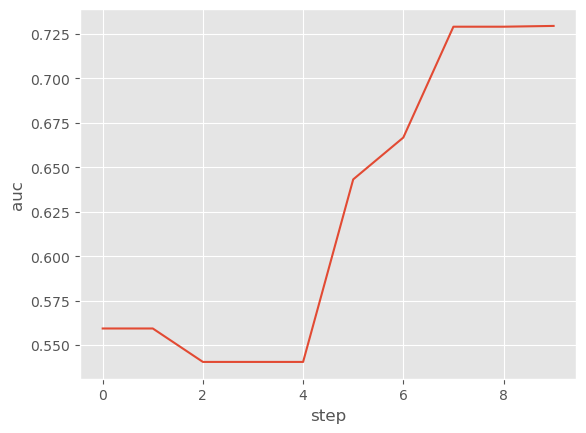

In [12]:
# Plot auc
plt.plot(range(num_samples), aucs)
plt.xlabel('step')
plt.ylabel('auc')

In [13]:
trackers = b_learner.get_param_trackers()

Text(0, 0.5, 'pct_good_examples')

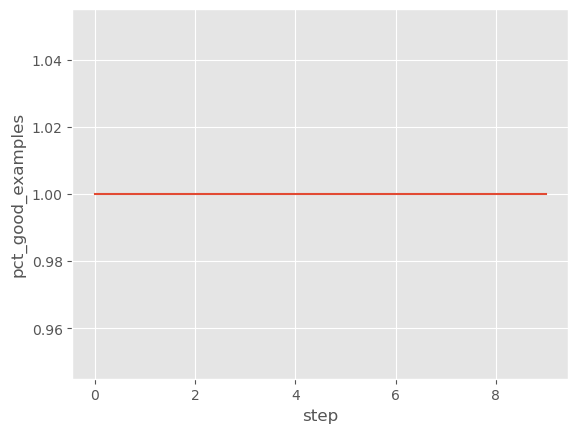

In [14]:
plt.plot(range(num_samples), trackers["pct_good_examples"])
plt.xlabel('step')
plt.ylabel('pct_good_examples')

Text(0, 0.5, 'n_seen_feats')

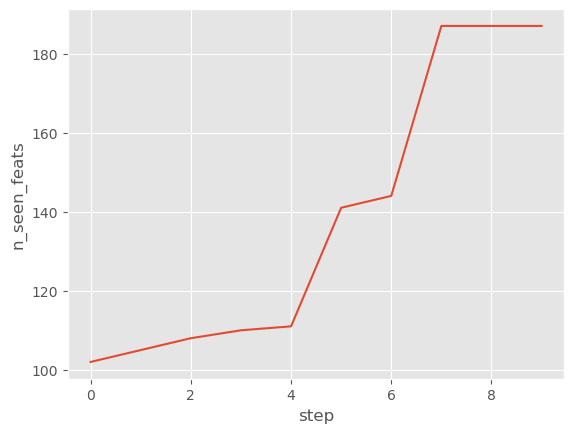

In [15]:
plt.plot(range(num_samples), trackers["n_seen_feats"])
plt.xlabel('step')
plt.ylabel('n_seen_feats')

Text(0, 0.5, 'proposed=train')

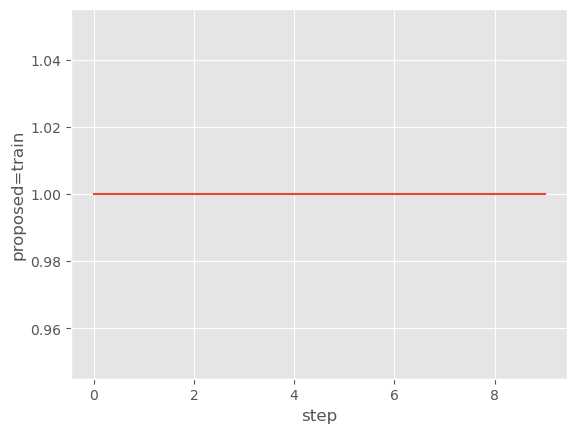

In [16]:
plt.plot(range(num_samples), np.array(np.array(trackers["proposed_from"])=="train", float))
plt.xlabel('step')
plt.ylabel('proposed=train')

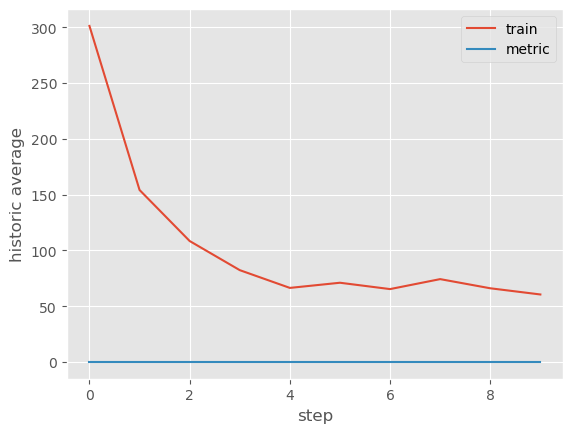

In [17]:
plt.plot(range(num_samples), trackers["train_avgs"], label="train")
plt.plot(range(num_samples), trackers["metric_avgs"], label="metric")
plt.xlabel('step')
plt.ylabel('historic average')
plt.legend()

Text(0, 0.5, 'alpha_mu')

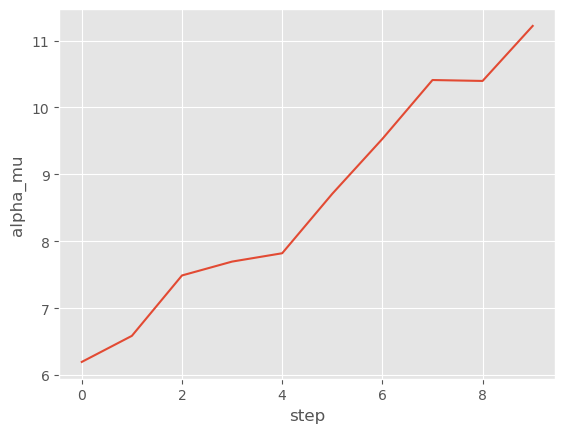

In [18]:
plt.plot(range(num_samples), trackers["alpha_mu"])
plt.xlabel('step')
plt.ylabel('alpha_mu')

Text(0, 0.5, 'alpha_sigma')

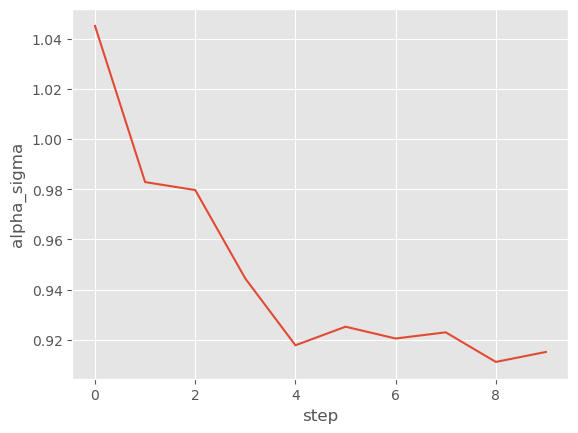

In [19]:
plt.plot(range(num_samples), trackers["alpha_sigma"])
plt.xlabel('step')
plt.ylabel('alpha_sigma')

Text(0, 0.5, 'avg_beta_mu')

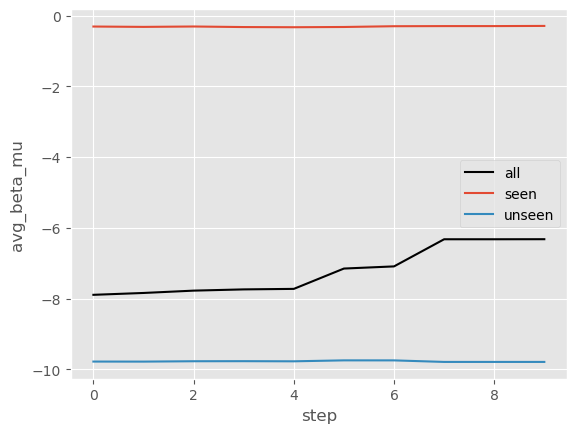

In [20]:
plt.plot(range(num_samples), trackers["avg_beta_mu"], color='k', label="all")
plt.plot(range(num_samples), trackers["avg_seen_beta_mu"], label="seen")
plt.plot(range(num_samples), trackers["avg_unseen_beta_mu"], label="unseen")
plt.legend()
plt.xlabel('step')
plt.ylabel('avg_beta_mu')

Text(0, 0.5, 'avg_beta_sigma')

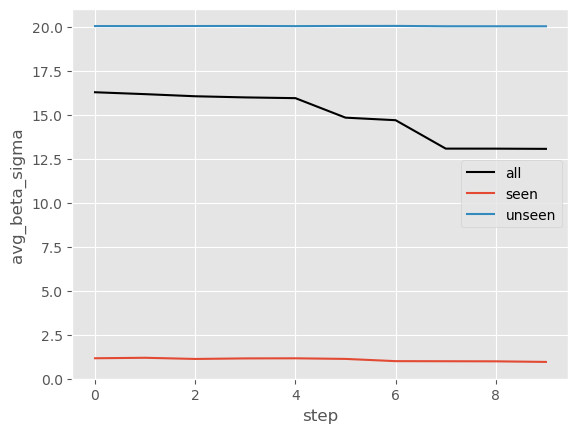

In [21]:
plt.plot(range(num_samples), trackers["avg_beta_sigma"], color='k', label="all")
plt.plot(range(num_samples), trackers["avg_seen_beta_sigma"], label="seen")
plt.plot(range(num_samples), trackers["avg_unseen_beta_sigma"], label="unseen")
plt.legend()
plt.xlabel('step')
plt.ylabel('avg_beta_sigma')